# Making some Mars maps with pygmt

This tutorial page covers the basics of creating some maps and 3D plot of Mars (yes! Mars). The idea here is to demonstrate that you can use a simple sequence of commands with PyGMT, a Python wrapper for the Generic Mapping Tools (GMT), and with some public data about the topography of Mars, create your own maps, as well as compare this topography with what we know of our own planet Earth.

## first, some options

You can run this notebook using your local pygmt installation, or via Binder, or even Google Colaboratory. See comments for each option below. 

**A)** A short note if you are using COLAB

The version of python in COLAB is different from what the newer GMT needs to install along with pygmt. So, one way around this problem is to reinstall GMT from scratch, along with other important packages. This is done with this block of commands below.

**comment out the first line of the block (%%script echo skipping) if you want to use colab**

In [ ]:
%%script echo skipping

# because I like to enjoy my coffee in silence, it takes time.  
# (3 runs averaged 6 minutes to install everything ! keep drinking your coffee)
# comment the %%capture line if you want to see the colab VM working
%%capture
!sudo apt update 
!sudo apt upgrade -y
!sudo apt install -y build-essential cmake libcurl4-gnutls-dev libnetcdf-dev gdal-bin libgdal-dev libfftw3-dev libpcre3-dev liblapack-dev libblas-dev libglib2.0-dev ghostscript ghostscript-x graphicsmagick ffmpeg xdg-utils
# clone gmt from source
!git clone --depth 50 https://github.com/GenericMappingTools/gmt
# cmake everything
!cmake /content/gmt
# build and install
!cmake --build . --target install

# and last but not least
!pip install pygmt

# and if you don't believe in it
!gmt --version
!python --version

In [ ]:
%%script echo skipping

# Also, if you are in colab or trying from your jupyter, you will need the Mars Topography (MOLA) already in Netcdf
# a copy of the original file distributed from the Mars Climate Database,
# from the European Space Agency under ESTEC contract 11369/95/NL/JG(SC) and Centre National D'Etude Spatial
# is in the gdrive.

!gdown 1fDzz8AxR1T58y0IGPhmbb1ZwrTLckp2G

**B)** Now, if you are using Binder or in your local jupyter

You just skip the block above. Make sure you have the `mola32.nc` in your folder.


In [1]:
%matplotlib inline

## Mars dataset

First, we open the `mola32.nc` file using xarray. Note the longitudes are from 0-360°, latitudes are distributed from North to South and the `alt`variable is the MOLA Topography at 32 pixels/degree built from original MOLA file `megt90n000fb.img`.

In [2]:
import xarray as xr 

dset_mars = xr.open_dataset('mola32.nc')
dset_mars

<xarray.Dataset>
Dimensions:    (latitude: 5760, longitude: 11520)
Coordinates:
  * latitude   (latitude) float32 89.98 89.95 89.92 ... -89.92 -89.95 -89.98
  * longitude  (longitude) float32 0.01562 0.04688 0.07812 ... 359.9 360.0 360.0
Data variables:
    alt        (latitude, longitude) int16 ...
Attributes:
    title:    MOLA Topography - 32 pixels/degree
    history:  Built from original MOLA file megt90n000fb.img

Just like any other notebook with pygm, we import the library and manipulate other data. To make a map of the entire Martian surface without a lot of time and memory, let's reduce the resolution using `grdsample`. We also take the opportunity to transform an `alt` variable into a `float` to be used in maps.

In [3]:
import pygmt 

# convert from int16 to float
dset_mars_topo = dset_mars.alt.astype(float)

# May be a global Mars map is very insteresting. We just need to get a better resolution not to consume all memory
# translate here changes from grid to pixel registration and spacing sets to 1 degree resolution
dset_mars_topo = pygmt.grdsample(grid=dset_mars_topo,translate=True,spacing=[1,1])

# don't be worried about the warnings.

grdsample [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdsample [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdsample (gmtapi_init_grdheader): Please select compatible -R and -I values
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


Here we can create a map of the entire Martian surface, in the same projections we use for our planet.

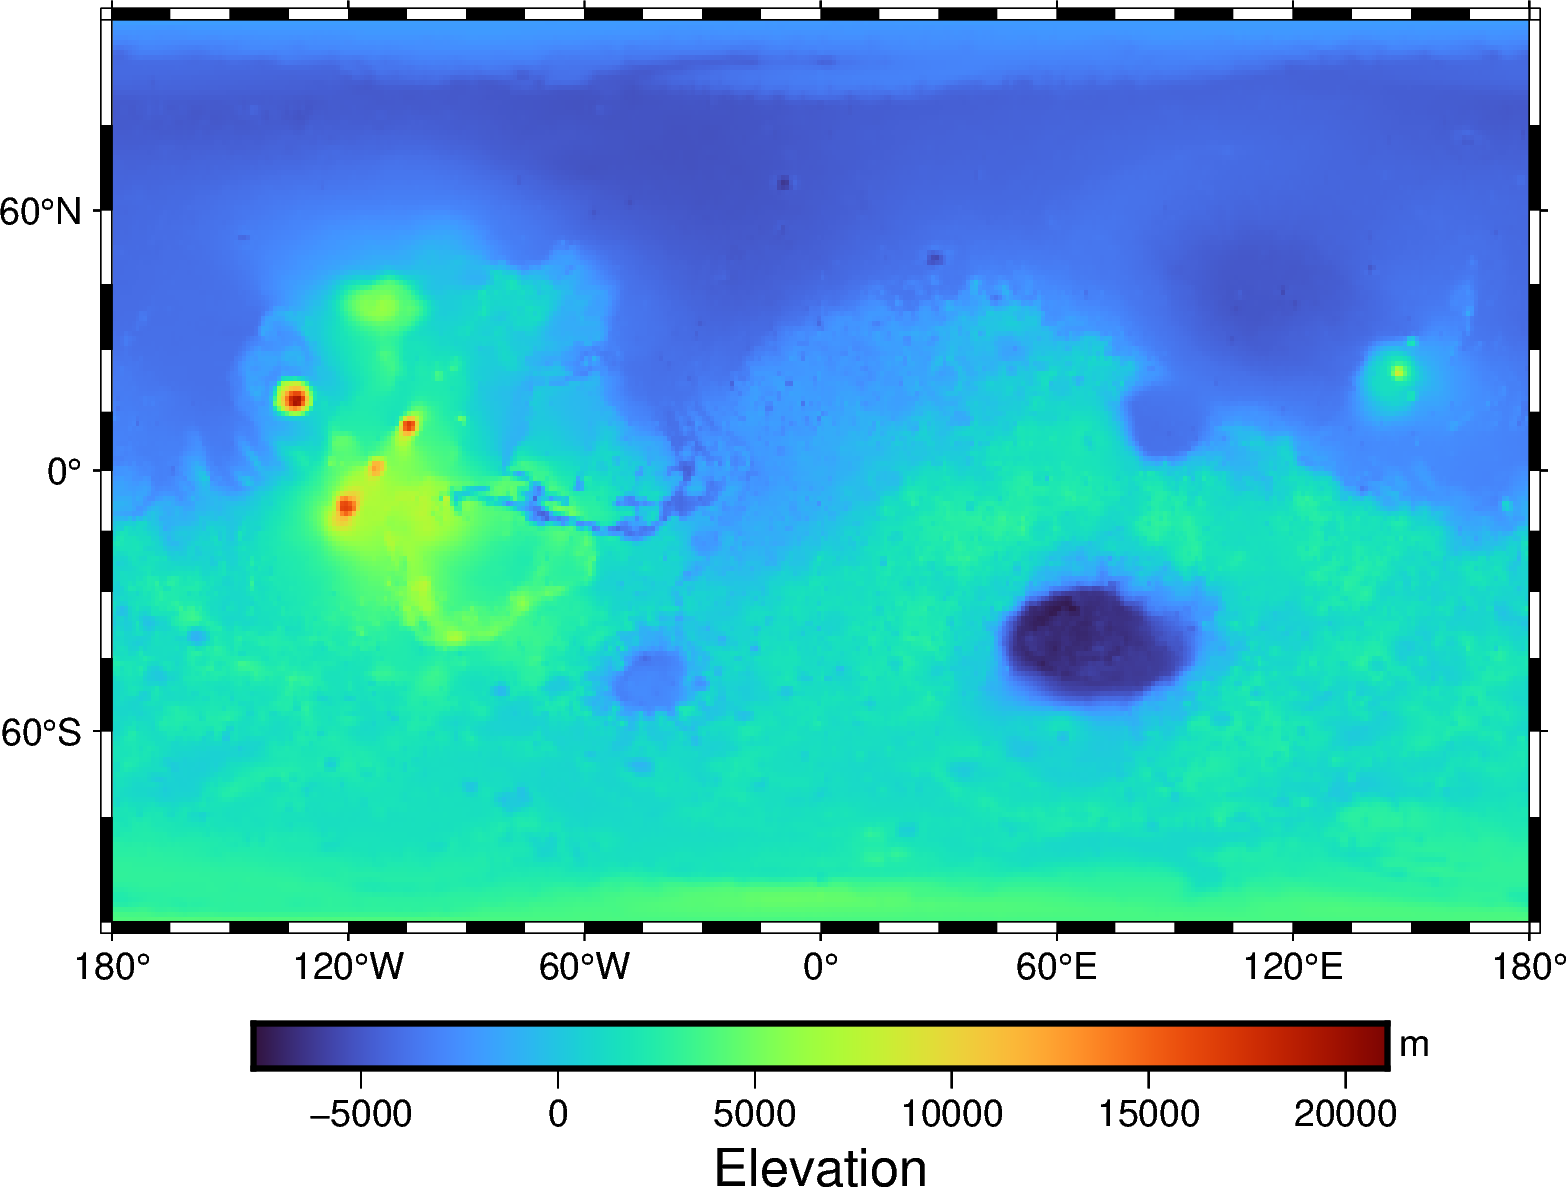

In [4]:
fig = pygmt.Figure()

fig.grdimage(grid=dset_mars_topo,region='g',frame=True,projection='Cyl_stere/0/0/12c')
# you can try with different cylindrical or miscellaneous projections
# see at https://www.pygmt.org/dev/projections/index.html
# some ideas: Eckert IV = Kf; Hammer = H; Mollweide = W

fig.colorbar(frame=["a5000", "x+lElevation", "y+lm"])
fig.show()

A very interesting feature is Mount Olympus (Olympus Mons - see more details at https://mars.nasa.gov/resources/22587/olympus-mons), centered at approximately 19°N and 133°W, with a height of 22 km (14 miles) and approximately 700 km (435 miles) in diameter. Let's use the original dataset at 32 pixels/degree resolution and plot a (not so interesting) map with `xarray`.

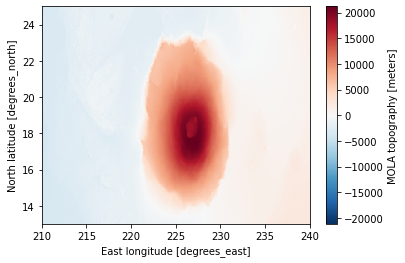

In [5]:
# Olympus Mons is located in these slices of 12 degrees of latitude and 30 degrees of longitude
# note we are cutting the region of interest and converting here the original "alt" data in int16 to float (for grid)
dset_olympus = dset_mars.sel(latitude=slice(25,13),longitude=slice(210,240)).alt.astype('float')
dset_olympus.plot()

We use the same sequence as other pygmt tutorial notebooks to make a map.

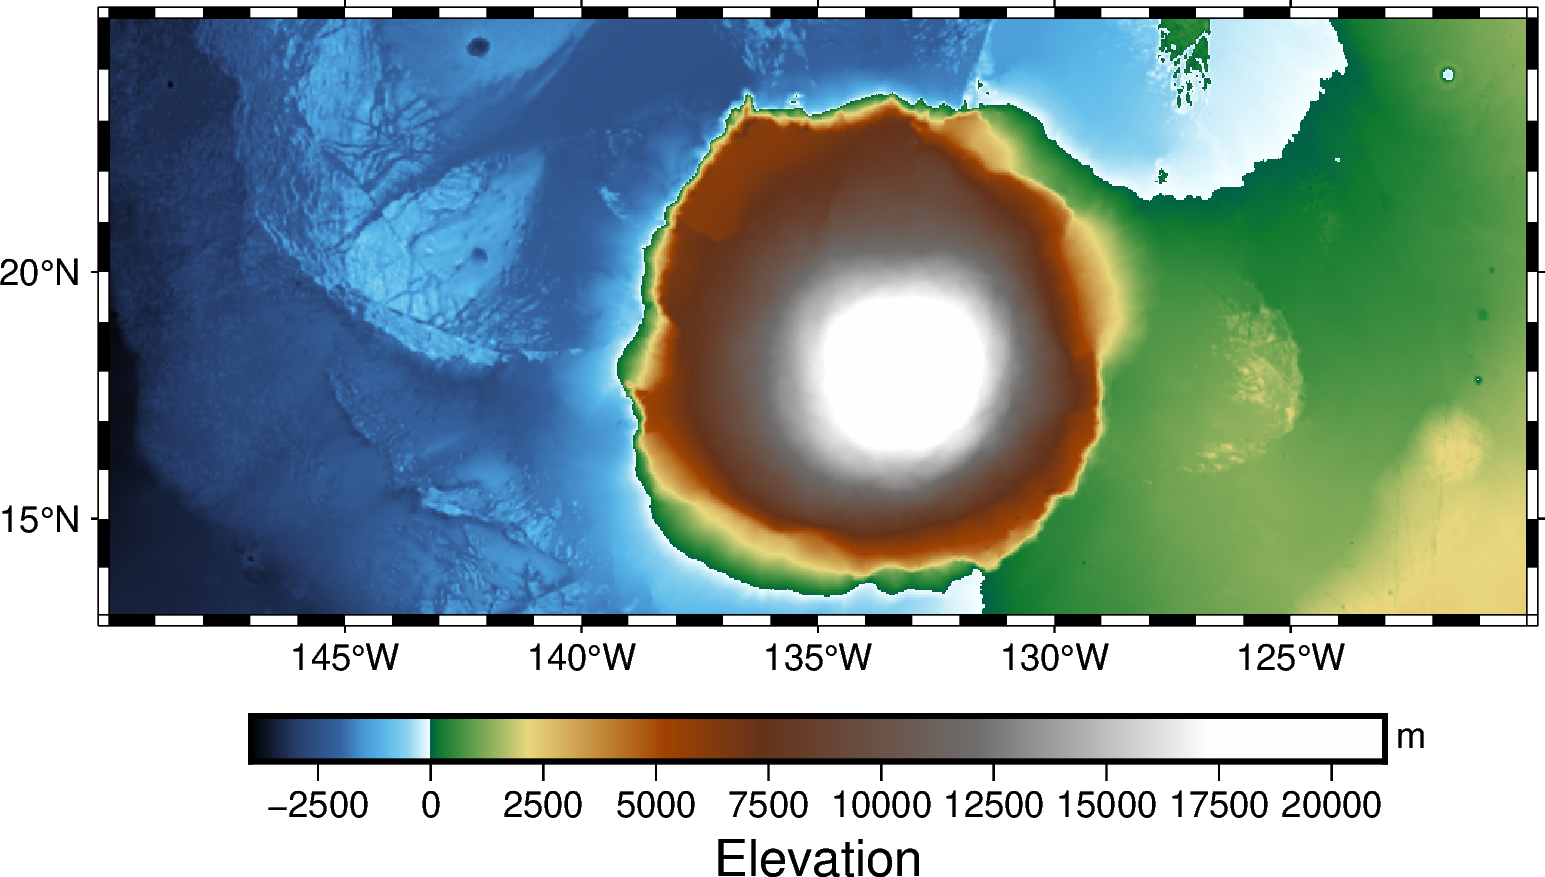

In [6]:
# first things, first
fig = pygmt.Figure()
# note I can add projection, after cmap and after, frame (and control frame)
fig.grdimage(grid=dset_olympus,projection='M12c',frame='a5f1',cmap='geo')
# also, I can add a colorbar (later)
fig.colorbar(frame=["a2500", "x+lElevation", "y+lm"])

fig.show()

And we're going to add some perspective, as well as a more interesting color scale. For ease of understanding, let's separate the region of interest with the same cutout that we created the base of the Olympus Mons topography dataset.

**A few notes**

`zsize` is a bit critical here because the volcano is very big (28 km if we consider -5000 to +23000 m). Likewise, `perspective=[150.45]` was choosen attempting (it's a matter of taste) and depends of which flank of the volcano you want to show. But this choice has to be made according to `shading` since to give a good 3D impression, the lighting must be adjusted according to the elevation and azimuth of the perspective. Finally, the pen outline is made smooth and small to enhance the contours of the topography.

Finally, let's make a combined map showing the planet in an inset in the upper right corner. We use the same bounding box coordinates used to cut out the topography, drawing in red on the map. Obviously here the color scale is the same.

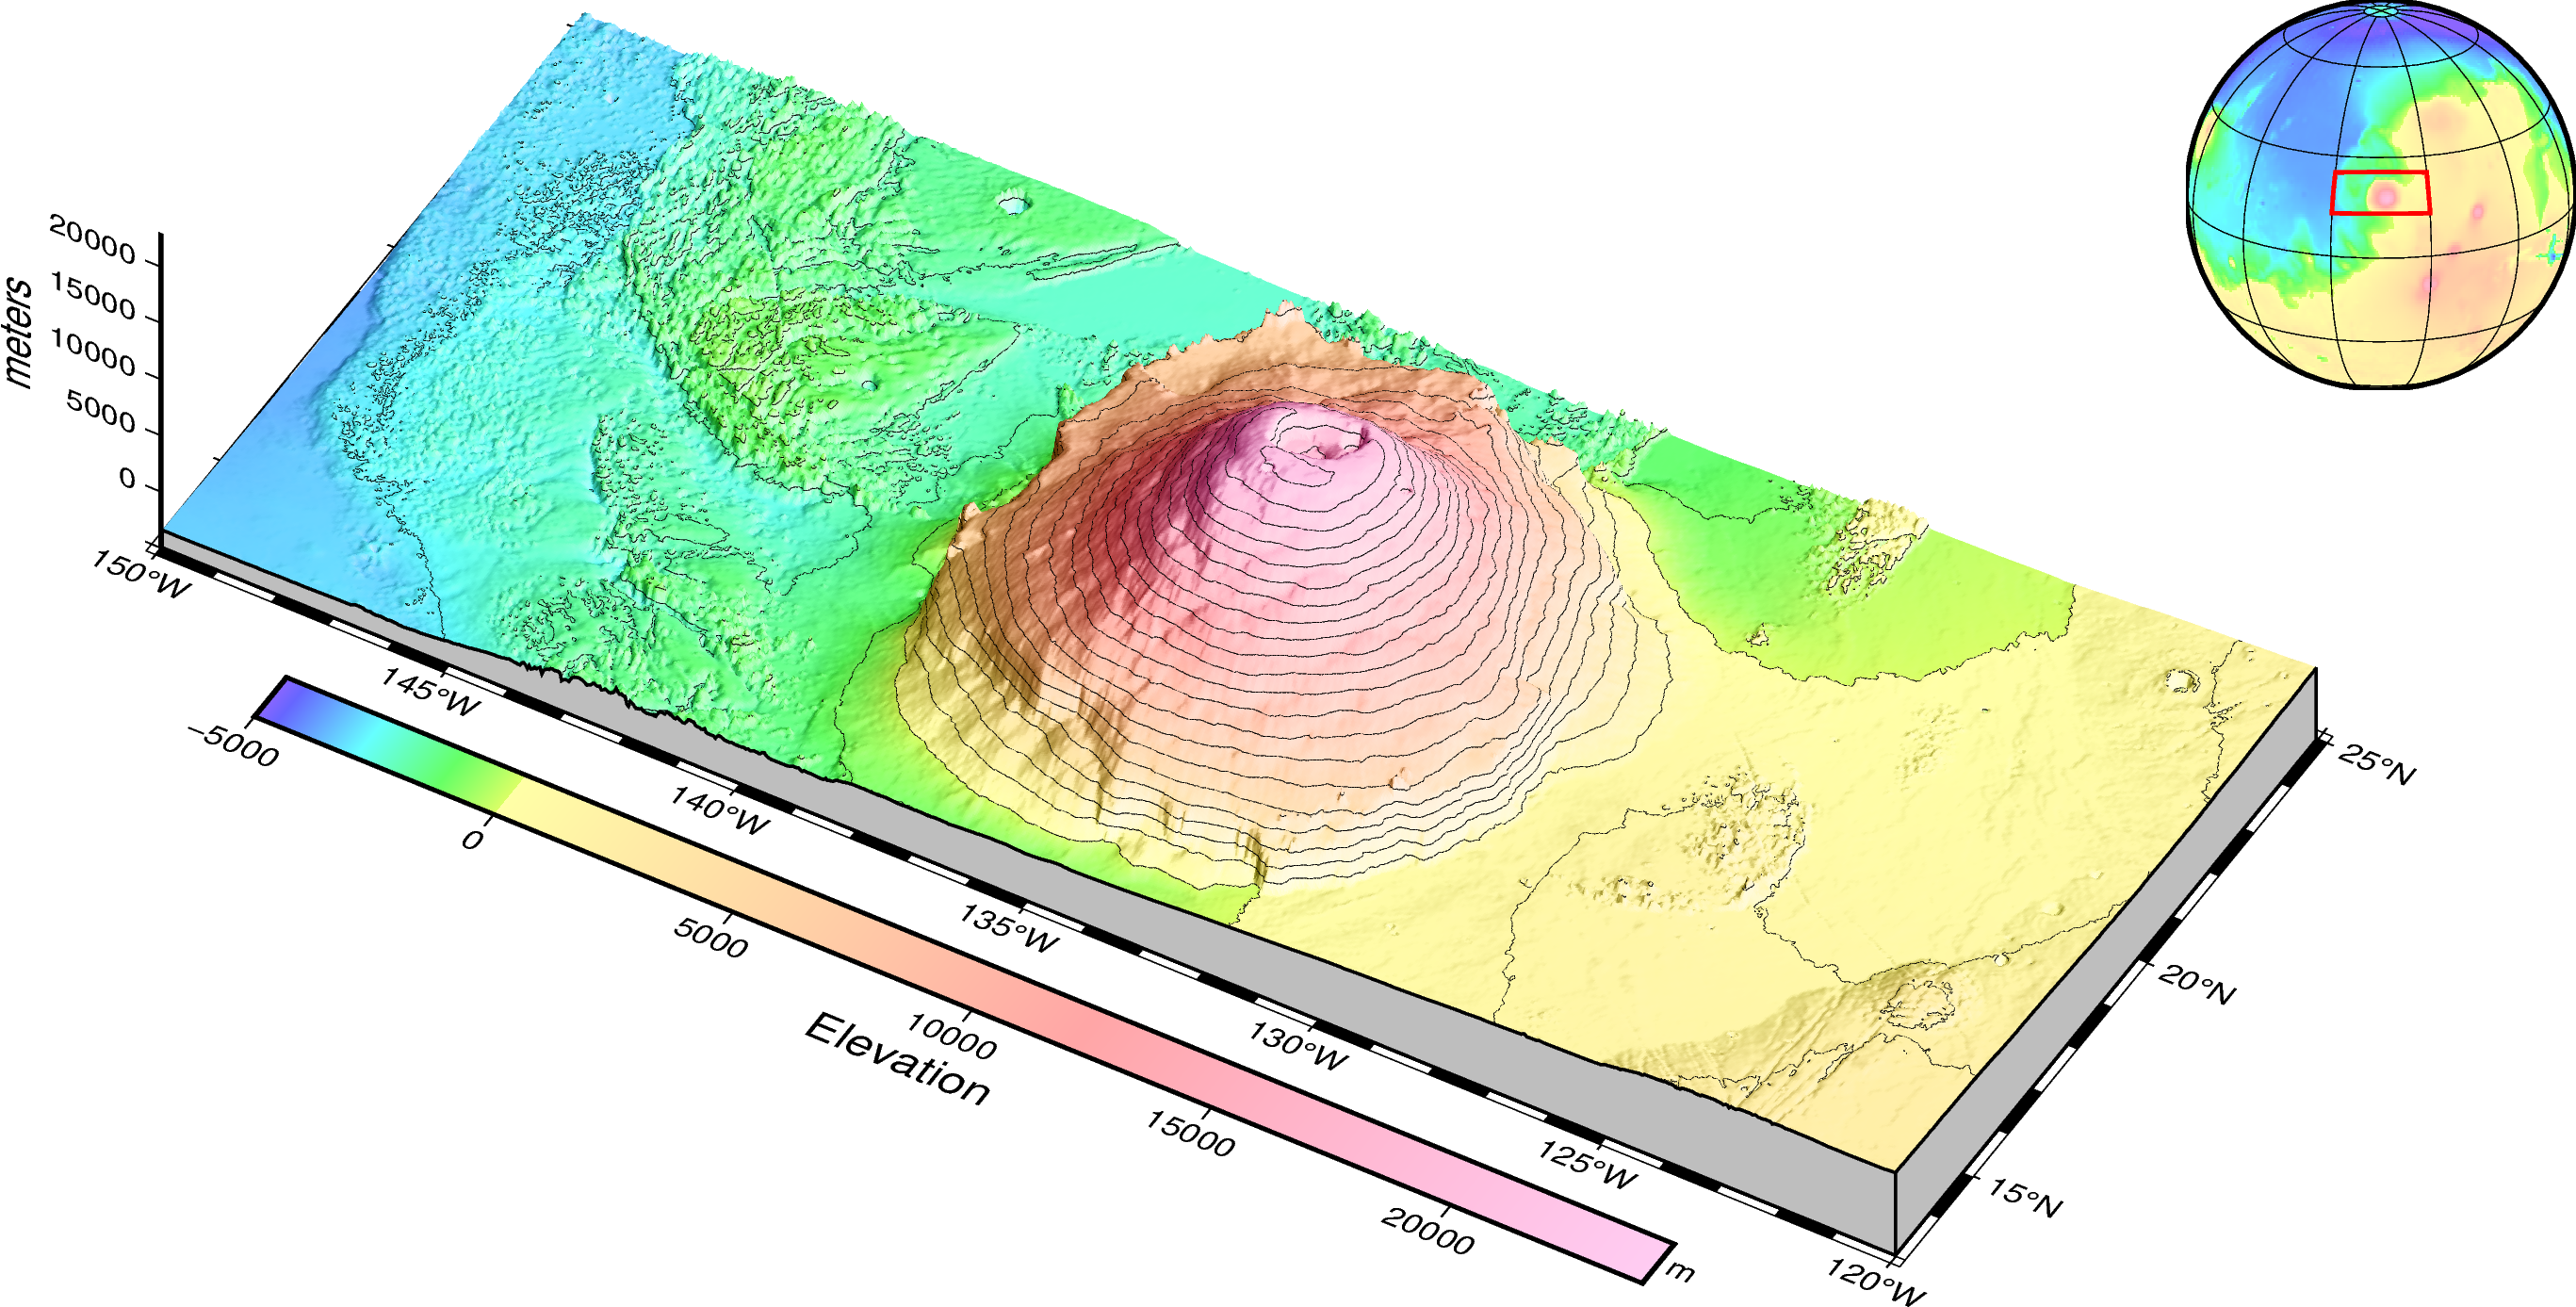

In [7]:
# a little perspective

fig = pygmt.Figure()
# note I can add projection, after cmap and after, frame (and control frame)
topo_cpt = pygmt.makecpt(cmap='sealand',series=f'-5000/24000/1000',continuous=True)
frame =  ["xa5f1","ya5f1", "z5000+lmeters", "wSEnZ"]

fig.grdview(grid=dset_olympus,
            region=[210,240,13,25,-5000,23000],
            frame=frame,
            perspective=[150,45],
            projection='M18c',
            zsize='4c',
            surftype='s',
            cmap=topo_cpt,
            plane="-5000+ggrey",
            shading='+a100+nt1',
            # Set the contour pen thickness to "0.1p"
            contourpen="0.1p",)

fig.colorbar(perspective=True, frame=["a5000", "x+lElevation", "y+lm"])

bounds = [[210.,13.],
          [210.,25.],
          [240.,25.],
          [240.,13.],
          [210.,13.]]

with fig.inset(position="JTR+w3.5c+o0.2c", margin=0, box=None):
    # Create a figure in the inset using the global projection centered at Olympus MOns
    fig.grdimage(grid=dset_mars_topo,region='g',frame='g',projection='G225/19/3.5c"')
    fig.plot(bounds,pen="1p,red")
fig.show()

## Now, how about Hawaii?

When we read about Olympus Mons, it is usually compared to Everest here on Earth. However, the most interesting thing is to compare it with another mountain range taking as a reference the abyssal seabed (without the ocean) - Hawaii. Interestingly, in terms of latitudes and longitudes on the planet, these two features are in almost the same position. To match the approximate dimensions, let's crop a sample of the `Earth Global Relief` using `pygmt.datasets` with slices of 12 degrees of latitude and 30 degrees of longitude.

In [8]:
# get etopo around Hawaii 
topo_hawaii = pygmt.datasets.load_earth_relief(region=[-170,-140,13,25],resolution="05m")

# and get the whole Earth at the same resolution of our low resolution Mars dataset
topo_globe = pygmt.datasets.load_earth_relief(region=[-180,180,-90,90],resolution="01d")

pygmt-session [WARNING]: File /home/abelem/.gmt/server/gmt_hash_server.txt.old said it has 181 records but only found 175 - download error???
pygmt-session [WARNING]: File /home/abelem/.gmt/server/gmt_hash_server.txt.old will be deleted.  Please try again
grdblend [NOTICE]: Remote data courtesy of GMT data server oceania [http://oceania.generic-mapping-tools.org]
grdblend [NOTICE]: SRTM15 Earth Relief at 05x05 arc minutes reduced by Gaussian Cartesian filtering (9.3 km fullwidth) [Tozer et al., 2019].
grdblend [NOTICE]:   -> Download 180x180 degree grid tile (earth_relief_05m_p): S90W180
grdcut [NOTICE]: Remote data courtesy of GMT data server oceania [http://oceania.generic-mapping-tools.org]
grdcut [NOTICE]: SRTM15 Earth Relief at 1x1 arc degrees reduced by Gaussian Cartesian filtering (111.2 km fullwidth) [Tozer et al., 2019].
grdcut [NOTICE]:   -> Download grid file [114K]: earth_relief_01d_p.grd


And we use the same sequence as above to make a map.

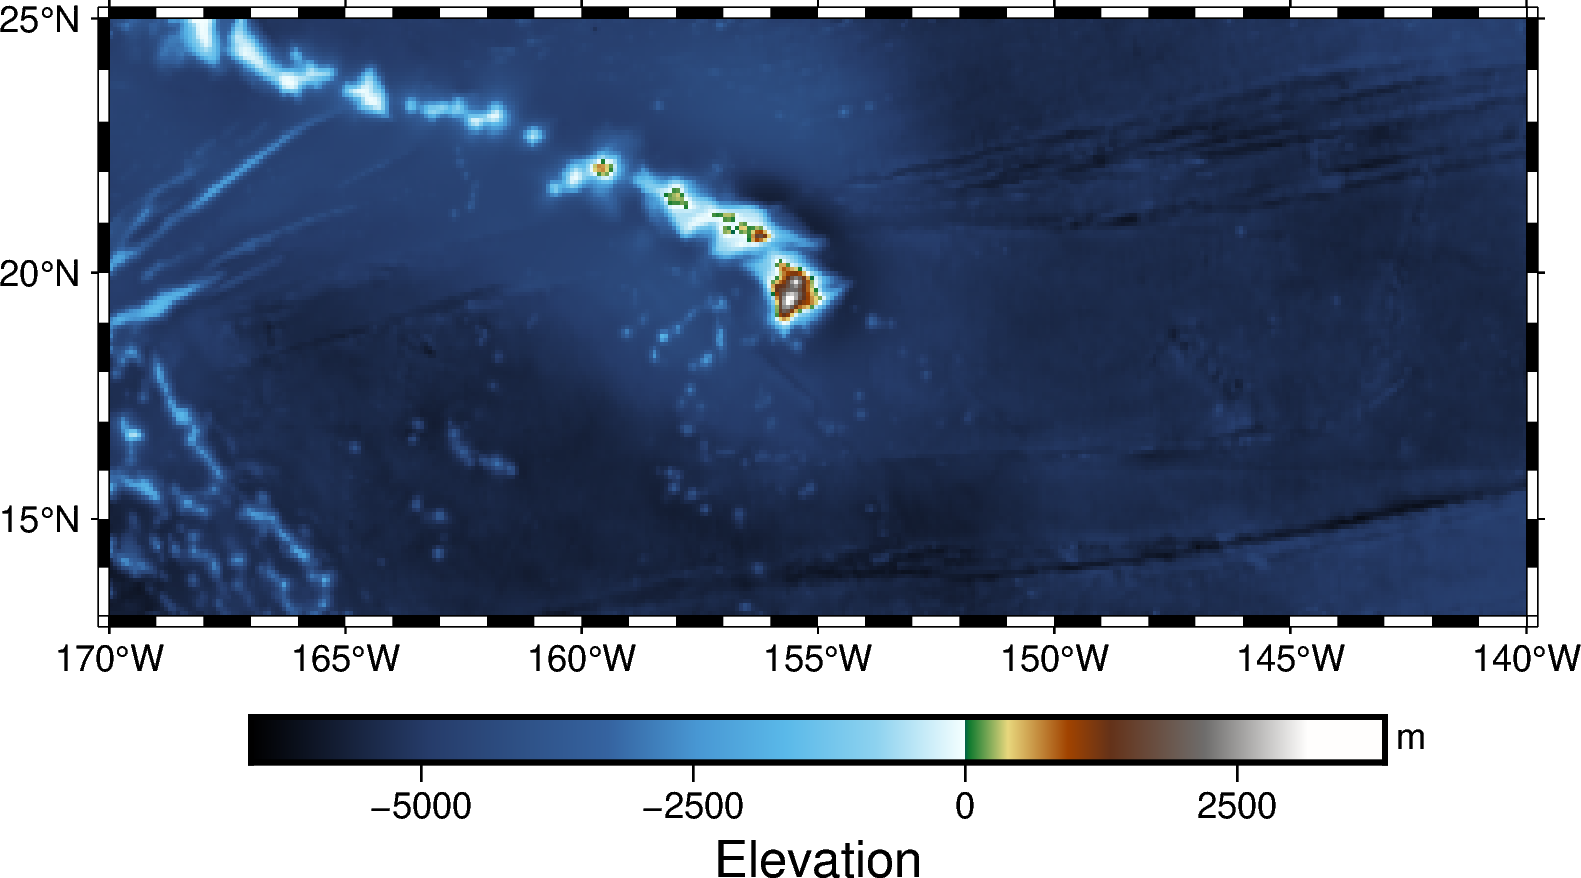

In [9]:
# second things, second

fig = pygmt.Figure()
# note I can add projection, after cmap and after, frame (and control frame)
fig.grdimage(grid=topo_hawaii,projection='M12c',frame='a5f1',cmap='geo')
# also, I can add a colorbar (later)
fig.colorbar(frame=["a2500", "x+lElevation", "y+lm"])

fig.show()

**Another few notes**

As we want to make a comparison, let's keep the same color scale as Mars, still using as a basis for the Z plane, -5000 meters (see the line `plane="-5000+ggrey"` exactly like the map above. The inset in the upper right corner is the same and we adjust the bounding box coordinates used to cut out the topography, drawing in red on the map. 

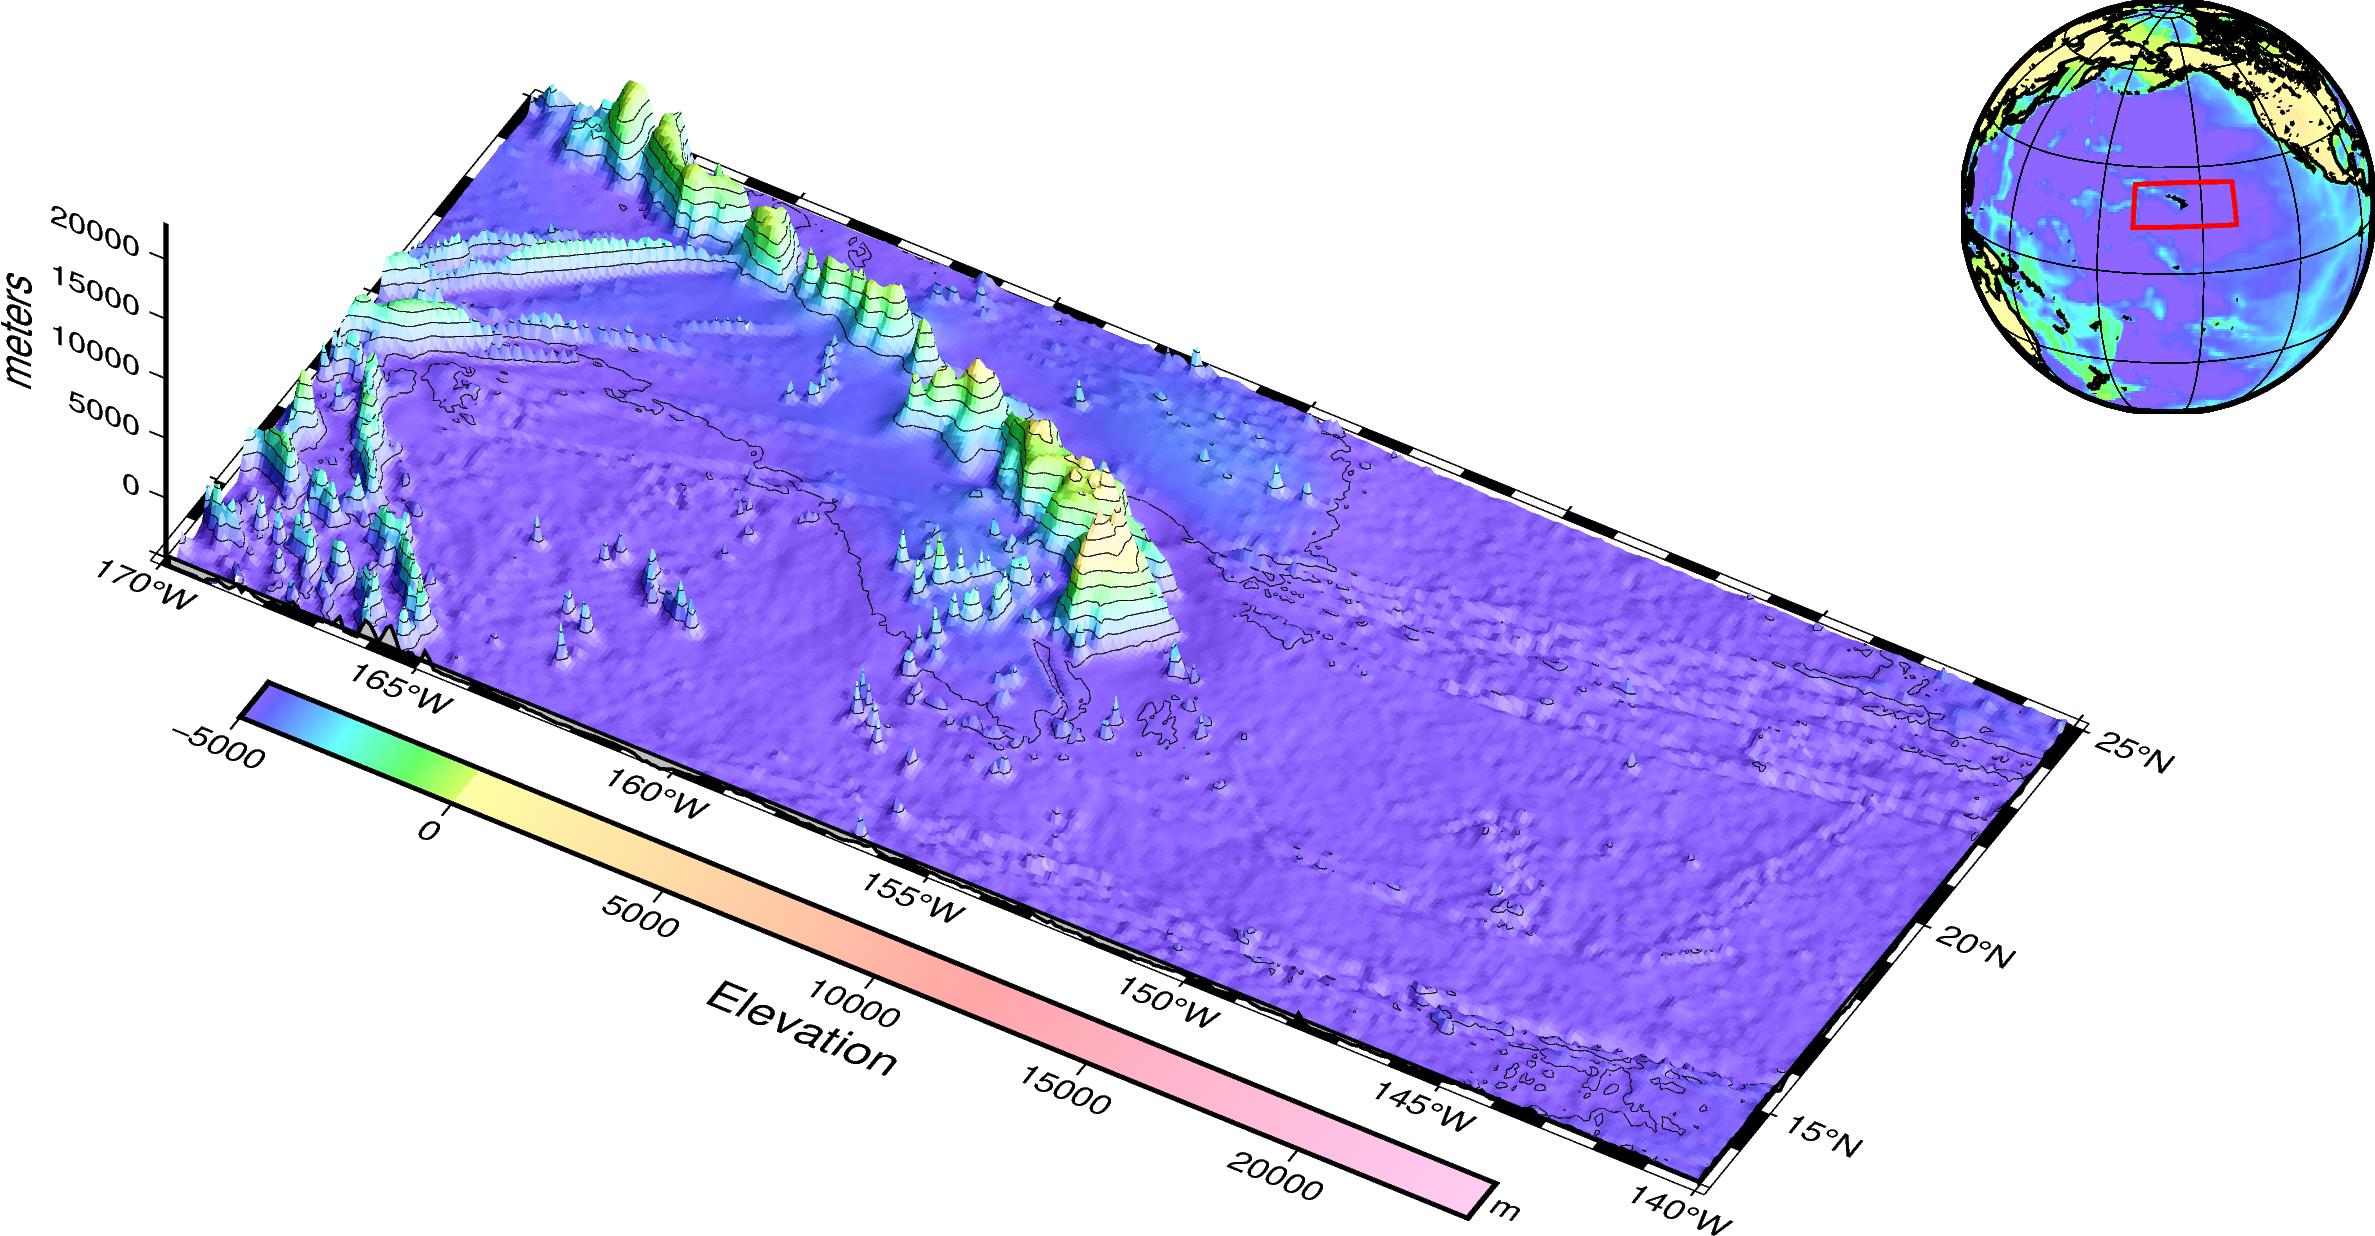

In [10]:
fig = pygmt.Figure()
# note I can add projection, after cmap and after, frame (and control frame)
frame =  ["xa5f1","ya5f1", "z5000+lmeters", "wSEnZ"]

topo_cpt = pygmt.makecpt(cmap='sealand',series=f'-5000/24000/1000',continuous=True)

fig.grdview(grid=topo_hawaii,
            region=[-170,-140,13,25,-5000,23000],
            frame=frame,
            perspective=[150,45],
            projection='M15c',
            zsize='4c',
            surftype='s',
            cmap=topo_cpt,
            plane="-5000+ggrey",
            shading='+a100+nt1',
            # Set the contour pen thickness to "0.1p"
            contourpen="0.1p",)

fig.colorbar(perspective=True, frame=["a5000", "x+lElevation", "y+lm"])

bounds = [[-170.,13.],
          [-170.,25.],
          [-140.,25.],
          [-140.,13.],
          [-170.,13.]]

with fig.inset(position="JTR+w3.5c+o0.2c", margin=0, box=None):
    # Create a figure in the inset using the global projection centered at Olympus MOns
    fig.grdimage(grid=topo_globe,region='g',frame='g',projection='G-160/19/3.5c"')
    fig.coast(region='g',shorelines="thin", frame="g")
    fig.plot(bounds,pen="1p,red")
    
fig.show()

## Combining the two maps side by side

Basically it's the same blocks as above, just using `pygmt`'s `Figure.set_panel` mechanism to tile.

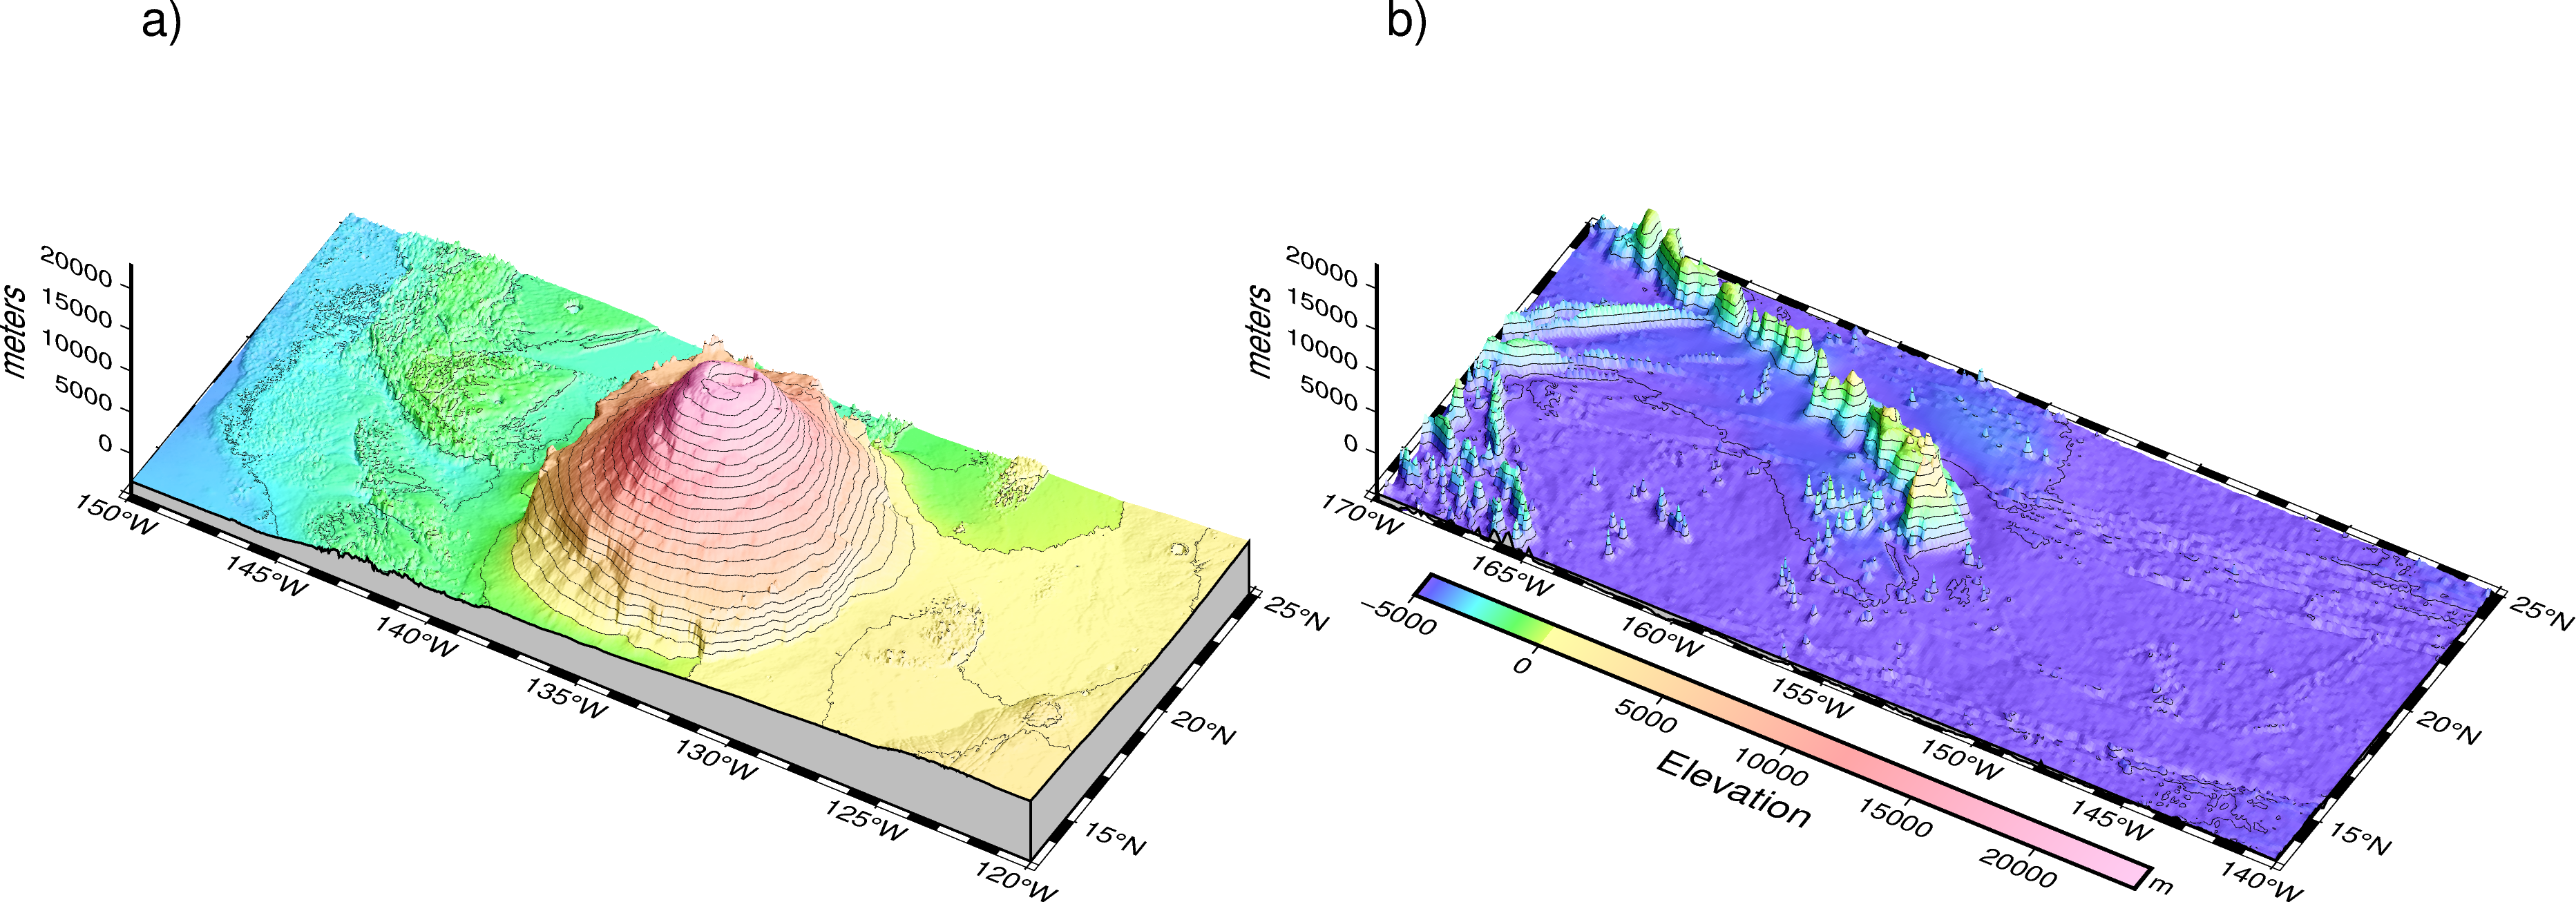

In [14]:
fig = pygmt.Figure()

with fig.subplot(
    nrows=1, ncols=2, figsize=("28c", "16c"), autolabel=True, margins="1c"
):
    with fig.set_panel(panel=0):

        topo_cpt = pygmt.makecpt(cmap='sealand',series=f'-5000/24000/1000',continuous=True)

        frame =  ["xa5f1","ya5f1", "z5000+lmeters", "wSEnZ"]

        fig.grdview(grid=dset_olympus,
                    region=[210,240,13,25,-5000,23000],
                    frame=frame,
                    perspective=[150,45],
                    projection='M',
                    zsize='4c',
                    surftype='s',
                    cmap=topo_cpt,
                    plane="-5000+ggrey",
                    shading='+a100+nt1',
                    # Set the contour pen thickness to "0.1p"
                    contourpen="0.1p",)

        # we don't need the colormap in both figures
        #fig.colorbar(perspective=True, frame=["a5000", "x+lElevation", "y+lm"])
        
    with fig.set_panel(panel=1):
        frame =  ["xa5f1","ya5f1", "z5000+lmeters", "wSEnZ"]

        topo_cpt = pygmt.makecpt(cmap='sealand',series=f'-5000/24000/1000',continuous=True)

        fig.grdview(grid=topo_hawaii,
                    region=[-170,-140,13,25,-5000,23000],
                    frame=frame,
                    perspective=[150,45],
                    projection='M',
                    zsize='4c',
                    surftype='s',
                    cmap=topo_cpt,
                    plane="-5000+ggrey",
                    shading='+a100+nt1',
                    # Set the contour pen thickness to "0.1p"
                    contourpen="0.1p",)

        fig.colorbar(perspective=True, frame=["a5000", "x+lElevation", "y+lm"])       

fig.show()

## Bonus map

Recently the rover Zhurong from the Tianwen-1's mission landed successfully at 109.926°E, 25.066°N, in southern Utopia Planitia on Mars (check out the article of Ye, B., Qian, Y., Xiao, L., Michalski, J. R., Li, Y., Wu, B., & Qiao, L. (2021). Geomorphologic exploration targets at the Zhurong landing site in the southern Utopia Planitia of Mars. Earth and Planetary Science Letters, 576, 117199. https://doi.org/10.1016/j.epsl.2021.117199). We can create a map of the region with the landing point.

First, let's locate Utopia Planitia. Take a look at Figure 1 by Ye et al. (2021).

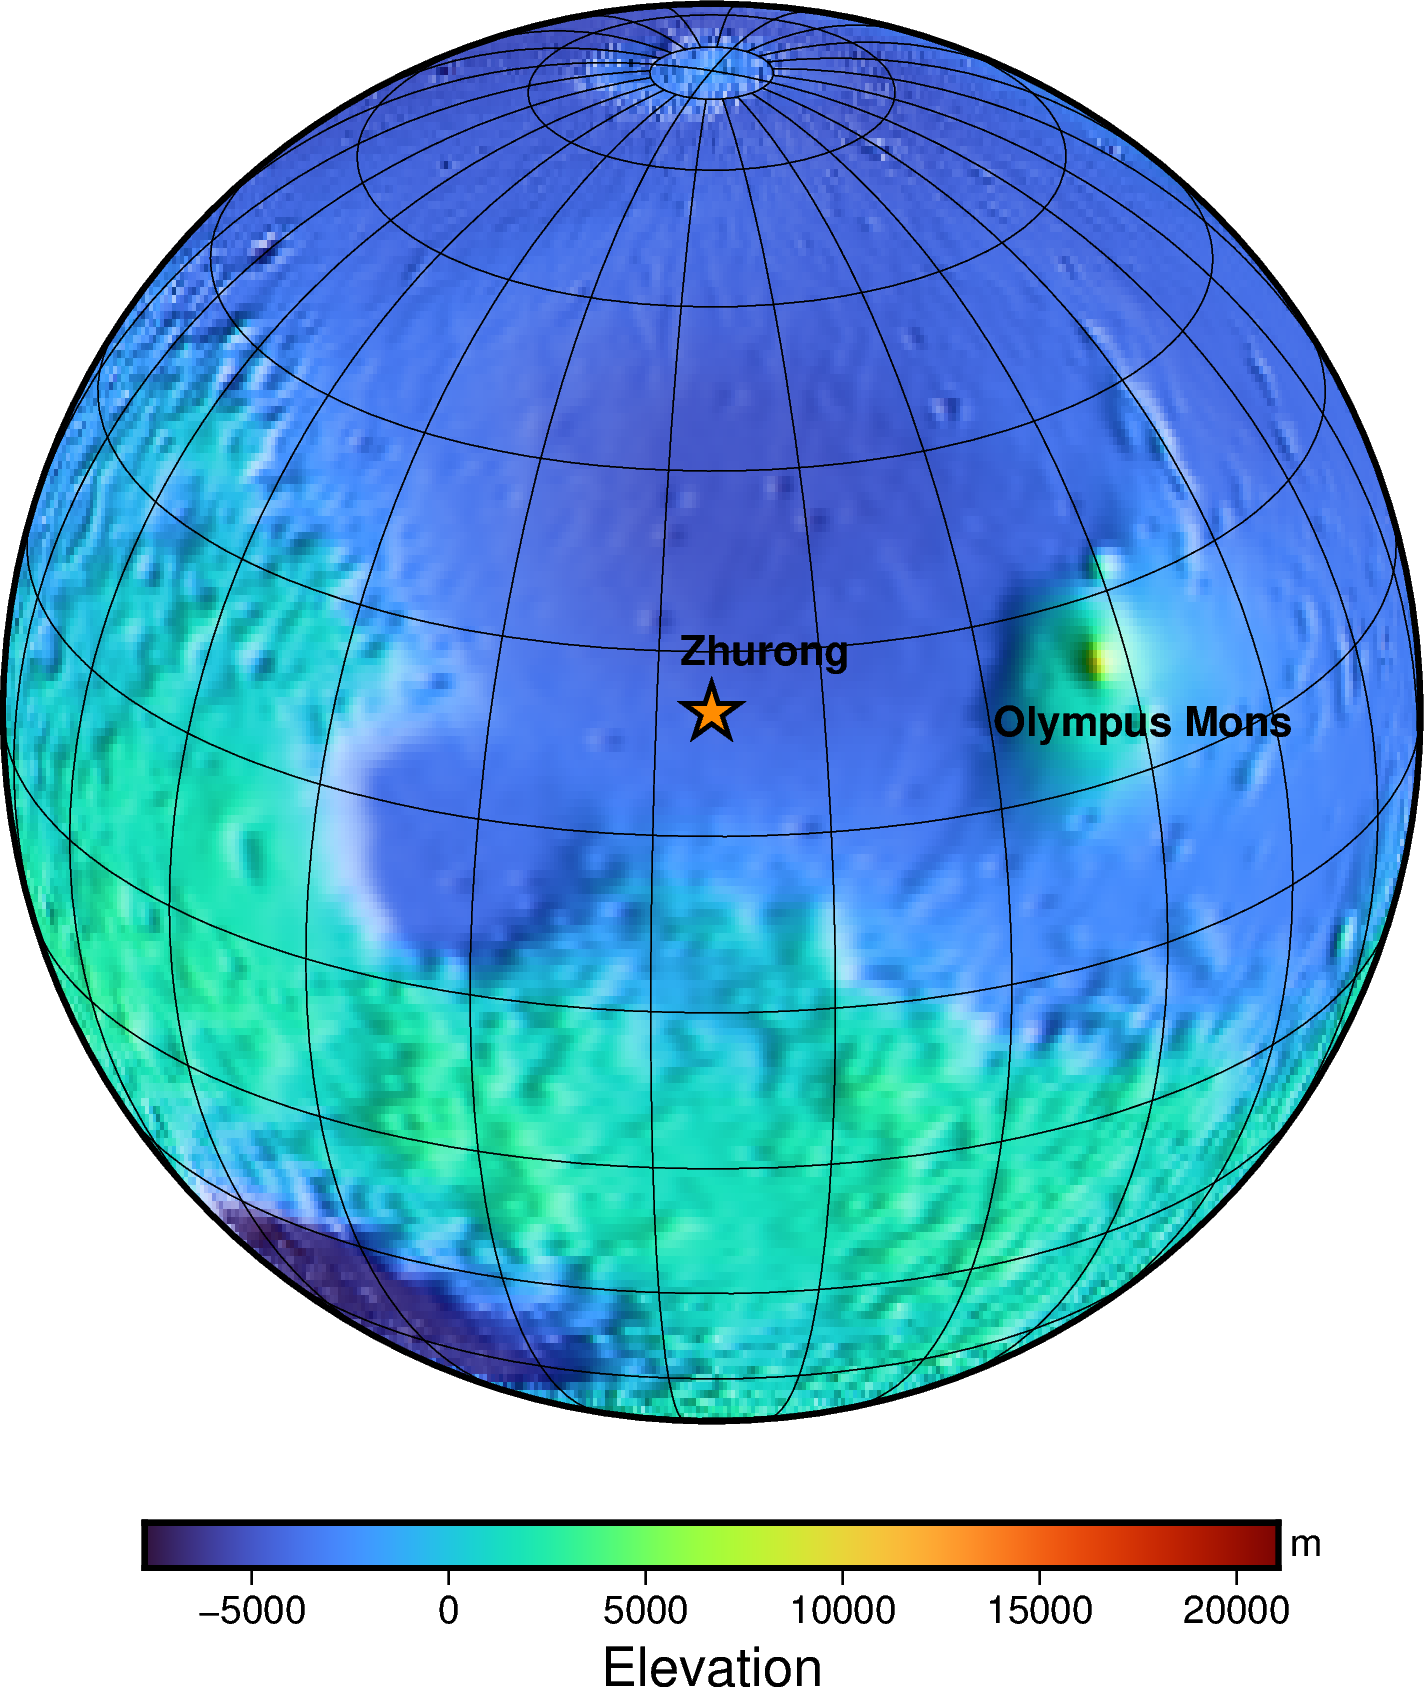

In [15]:
fig = pygmt.Figure()

# we are using a Orthographic view centered at the landing site
fig.grdimage(grid=dset_mars_topo,region='g',frame='g',projection='G109.926/25.066/12c"',shading='+a100+nt1')

zhurong = [109.926,25.066]
Olympus = [360-210,19.0] #position for Olympus Mons - see the letf border of the area

# and we drop a "star" in the landing site and write with a small displacement of text
fig.plot(x=zhurong[0],y=zhurong[1],style="a0.5c", pen="1p,black", color="darkorange")
fig.text(x=zhurong[0]+5,y=zhurong[1]+5, text="Zhurong", font='10p,Helvetica-Bold')

fig.text(x=Olympus[0],y=Olympus[1], text="Olympus Mons", font='10p,Helvetica-Bold')

fig.colorbar(frame=["a5000", "x+lElevation", "y+lm"])
fig.show()

# additional maps

1. You can use the same strategy as above to make a 3D map of the Zhurong landing and exploration area
2. Note that in this case you should use the MOLA dataset with the highest resolution.
3. Test different color palettes to see the result, and don't forget to manipulate perspective and shading accordingly.

We hope you enjoyed it.